In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.io as sio
import collections
import multiprocessing
import itertools
import networkx as nx
import sys

In [2]:
def squared_distance_matrix(X, augmented=False):
    """ Calculate the squared distance matrix for pointset X

        X               M by n pointset, with M number of points and n the dimension
        augmented       if True, the matrix will be augmented by a row and column of
                        zeros to make room for extra entries

        returns D, M by M array or (M+1) by (M+1) matrix

    """
    XX = np.dot(X,X.T)
    D = np.outer(np.diag(XX), np.ones(len(X)))-2*XX+np.outer(np.ones(len(X)),np.diag(XX))
    if augmented == True:
        n = len(D)
        zeros_v = np.zeros((n,1))
        zeros_h = np.zeros((1,n+1))
        D = np.bmat('D zeros_v; zeros_h')
    return D

def interpolate_spline(y, N):
    l = len(y)
    x = np.linspace(0, l, l)
    spline = interpolate.InterpolatedUnivariateSpline(x,y)
    xnew = np.linspace(0, l, N*l)
    ynew = spline(xnew)
    return ynew
    
def local_max(x, threshold=1e-5):
    """
        Get all local maxima of x by selecting all points which are 
        higher than its left and right neighbour
    """
    maxima = np.r_[True, x[1:] > x[:-1]] & np.r_[x[:-1] > x[1:] , True]
    # select all local maxima above the threshold
    maxima_f = maxima & np.r_[x > threshold , True][:-1]
    peak_indices =  np.where(maxima_f==True)[0]
    return np.array(peak_indices)
 
def direct_sound(x):
    all_peak_indices = local_max(x,threshold=1e-5)
    i = np.argsort(x[all_peak_indices])
    direct_sound_index = all_peak_indices[i][-1]
    peak_indices = all_peak_indices[np.where(all_peak_indices < direct_sound_index)[0]]
    values = x[peak_indices]
    # direct sound side lobe range
    rng = direct_sound_index - max(peak_indices[np.where(values < (x[direct_sound_index] * 0.02))[0]])
    return direct_sound_index, rng, all_peak_indices    

def locate_source(p,d):
    """ Locate source x using multilateration

        p    sensors as a Mxn arraylike with M, number of sensors and n the dimension
        d    distances from x to all sensors in d

        returns x
    """
    # M = sensors, n = dimensions
    M, n = p.shape
    p = np.matrix( p ).T

    # pick closest receiver
    c = np.argmin(d)
    #sensors delta time relative to sensor c
    d = d - min(d)

    indices = list(range(M))
    del indices[c]

    A = np.zeros([M-2,n])
    b = np.zeros([M-2,1])

    i = indices[0]
    for row,j in enumerate(indices[1:]):
        A[row,:] = 2*( (d[j])*(p[:,i]-p[:,c]).T - (d[i])*(p[:,j]-p[:,c]).T )
        b[row,0] = (d[i])*((d[j])**2-p[:,j].T*p[:,j]) + \
        ((d[i])-(d[j]))*p[:,c].T*p[:,c] + \
        (d[j])*(p[:,i].T*p[:,i]-(d[i])**2)


    x = np.asarray( np.linalg.lstsq(A,b)[0] )[:,0]
    return x

class MeasurementData:
    
    def __init__(self, data, receivers, sources, room_dimensions, c=343, fs=96000):
        """
        
        Container class for measurement data and parameters
        
        """
        self.data = data
        self.fs = fs
        self.c = c
        self.r = receivers
        self.s = sources
        self.L = room_dimensions
        self.upsampling_rate = 1
           
    def crop(self, N):
        self.data = self.data[:,:N]
        
    def interpolate(self, N):
        self.upsampling_rate *= N
        self.data = np.array([interpolate_spline(x,N) for x in self.data])
      
    def interpolate_parallel(self, N):
        with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:        
            self.new_data = np.array(pool.starmap(interpolate_spline, zip(self.data, itertools.repeat(N))))
            
    def find_echoes(self, n=7, correct_offset=True):
        echoes = np.zeros([len(self.data), n])
        for j,rir in enumerate(self.data):
            direct_sound_index, side_lobe_rng, all_peak_indices = direct_sound(rir)
            N = direct_sound_index + side_lobe_rng
            peak_indices = all_peak_indices[np.where(all_peak_indices > N)[0]]
            i = np.argsort(rir[peak_indices])
            sorted_peak_indices = peak_indices[i][::-1]
            echoes[j,:] = np.r_[direct_sound_index, sorted_peak_indices[:(n-1)]]
        
        echoes = echoes * self.c / (self.upsampling_rate * self.fs)
        if correct_offset == True:
            offset = self._calculate_offset()
            echoes += offset[:,np.newaxis]
        return echoes
            
    def _calculate_offset(self):
        direct_sound_distances = np.argmax(self.data, axis=1) * self.c / (self.upsampling_rate * self.fs)
        source_est = np.array(locate_source(self.r, direct_sound_distances))
        true_dist = np.linalg.norm(self.r - source_est, axis=1)
        offset = true_dist - direct_sound_distances
        return np.array(offset).T
    
        

In [82]:
def find_sorting_indices(x, Y):
    sort_i = np.zeros(len(x), dtype='int')
    for i,el in enumerate(x):
            sort_i[i] = np.where(el == Y)[0][0]
    return sort_i

def calc_rank(D, echo_set, t):
        D[-1,0:-1] = np.array(echo_set).reshape(1,len(echo_set))**2
        D[0:-1,-1] = np.array(echo_set).reshape(len(echo_set),1)**2
        rank = np.linalg.matrix_rank(D, t)
        return (rank, echo_set)

class EchoData:
    
    def __init__(self, data):
        self.data = data
        
    def find_labels(self, D, threshold=0.045, verbose=False, parallel=False):
        E = []
        S = []
        n = 6
        if verbose==True:
            print('Finding echo_set candidates per measurement ...')
        S.append(self.data[:,0])
        t = threshold
        Ei = np.array([])
        while len(Ei) < 1:
            Ci = self._get_candidates(D, t=t, parallel=parallel)
            if verbose == True:
                print('prefilter threshold:', t)
            t *= 2
            if len(Ci) > 100 or t > 8*threshold:
                break
            Ei = self._get_unique_sets(Ci, n=n)
        if 0 < len(Ei) < 20:
            u = np.unique(Ci[:,0])
            if len(u) >= n:
                for ei in Ei:
                    sort_i = find_sorting_indices(u, ei)
                    ei_sorted = ei[sort_i]
                    E.append(np.r_[self.data[:,0][np.newaxis,:], ei_sorted])
        sys.stdout.flush()
        if verbose==True:
            print('Number of unique sets of',n,'echo_sets:',len(E))
        return S,E


    def _get_unique_sets(self, C, n=6):
        G = nx.Graph()
        edge_list = []
        for i in range(len(C)):
            G.add_node(i)
            for j in range(i+1, len(C)):
                if np.any(C[i] - C[j] == 0):
                    edge_list.append((i,j))
        G.add_edges_from(edge_list)
        H = nx.complement(G)
        cliques = nx.find_cliques(H)
        return [C[l] for l in cliques if len(l) == n]

    
    def _get_candidates(self, D, t=0.0002, parallel=False):
        """
        Filters out all non-feasible combinations of echoes based on the rank test of the augmented Euclidean Distance Matrix D.
        If matrix D after augmenting with echo-data still passes the rank test, then the current set of echoes is saved.

        D       Euclidean distance matrix of size (6,6)
        t       rank test threshold

        returns list of candidate echo sets
        """
        
        if parallel==True:
            echo_sets = [echo_set for echo_set in itertools.product(*self.data[:,1:])]

            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                output = pool.starmap(calc_rank, zip(itertools.repeat(D), echo_sets, itertools.repeat(t)))

            ranks, echo_sets = zip(*output)
            candidates = [echo_set for rank, echo_set in output if rank < 6]            
            #i = np.where(np.array(ranks) < 6)[0]
            #candidates = np.array(echo_sets)[i]

        else:
            candidates = []
            for echo_set in itertools.product(*self.data[:,1:]):
                D[-1,0:-1] = np.array(echo_set).reshape(1,len(echo_set))**2
                D[0:-1,-1] = np.array(echo_set).reshape(len(echo_set),1)**2
                rank = np.linalg.matrix_rank(D, t)
                if rank < 6:
                    candidates.append(echo_set)
        return np.array(candidates)

In [92]:
def compute_sources_and_receivers(distance_data, dim):
    # number of sources and receivers
    M,N = distance_data.shape

    # construct D matrix
    D = distance_data**2

    # reconstruct S and R matrix up to a transformation
    U,si,V_h = np.linalg.svd(D)
    R_hat = np.mat(U[:,:dim].T)
    S_hat = np.mat(np.eye(dim)*si[:dim]) * np.mat(V_h[:dim,:])

    hr = np.ones((1,N)) * np.linalg.pinv(S_hat)
    I = np.eye(4)
    zeros = np.zeros((4,1))
    Hr = np.bmat('hr; zeros I')
    R_hatHr = (R_hat.T * np.linalg.inv(Hr)).H

    hs = np.linalg.pinv(R_hatHr).H * np.ones((M,1))
    zeros = np.zeros((1,4))
    Hs = np.bmat('I; zeros')
    Hs = np.linalg.inv(np.bmat('Hs hs'))

    S_prime = Hs*Hr*S_hat

    A = np.array(S_prime[4,:])
    XYZ = np.array(S_prime[1:4,:])
    X = np.array(S_prime[1,:])
    Y = np.array(S_prime[2,:])
    Z = np.array(S_prime[3,:])

    qq = np.vstack( (np.ones((1,N)), 2*XYZ, XYZ**2, 2*X*Y, 2*X*Z, 2*Y*Z) ).T
    q = np.linalg.pinv(qq).dot(A.T)
    Q = np.vstack( (np.hstack( (np.squeeze(q[:4].T), -0.5) ), np.hstack([q[1], q[4], q[7], q[8], 0]), np.hstack([q[2], q[7], q[5], q[9], 0]), np.hstack([q[3],q[8],q[9],q[6],0]), np.array([-0.5,0,0,0,0]) ) )

    if np.all(np.linalg.eigvals(Q[1:4,1:4]) > 0):
        C = np.linalg.cholesky(Q[1:4,1:4]).T
    else:
        C = np.eye(3)

    Hq = np.vstack((  np.array([1,0,0,0,0]),
                      np.hstack( (np.zeros((3,1)), C, np.zeros((3,1)))),
                      np.hstack( (-q[0], -2*np.squeeze(q[1:4].T), 1))
                    ))

    H = np.mat(Hq) * Hs * Hr
    Se = (H*S_hat)[1:4,:]
    Re = 0.5 * (np.linalg.inv(H).H*R_hat)[1:4,:]

    return Re, Se


def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T


    return R, t

def pair_iterator(list_of_lists):
    copy_list_of_lists = list(list_of_lists)
    for set1 in reversed(list_of_lists):
        copy_list_of_lists.pop()
        for set2 in copy_list_of_lists:
            for pair in itertools.product(set1,set2):
                yield pair

class DistanceData:
    
    def __init__(self, S, E):
        self.S = S
        self.E = E

    def find_images(self, r):
        results = {}
        for (E0, E1) in pair_iterator(self.E):
            data_hat = np.hstack( (np.array(self.S).T,(E0[1:,:]).T ,(E1[1:,:]).T) )
            error_r, s_est = self._compute_coordinates(data_hat, r)
            results[error_r] = (s_est, (E0, E1))
        return results

    def _compute_coordinates(self, data, r):
        """
        Test whether the input data can be used for localization of sources.

        data    distance data between N sources and M known receivers
        r       coordinates of M receivers

        returns (valid,r_est)

            valid   if True, r_est and s_est are correct estimations
            r_est   estimation of receiver locations
        """
        M, N = data.shape
        Re, Se = compute_sources_and_receivers(data, 5)
        # find transformation between R and Re
        R_r,t_r = rigid_transform_3D(np.mat(Re.T), np.mat(r))
        # find transformation between R and Re
        #Apply transformation on Re and Se to obtain estimated locations of sources
        r_est = np.array(R_r*np.mat(Re) + np.tile(t_r, (1,M)))
        s_est = np.array((-1*R_r)*np.mat(Se) + np.tile(t_r, (1,N)))

        error_r = np.linalg.norm(r_est.T - r, ord='fro') / np.sqrt(M)

        return error_r, s_est

In [111]:
class Line:

    def __init__(self, a,b,c):
        """ standard form a*x + b*y = c"""
        self.a = a
        self.b = b
        self.c = c

    def get_x(self,y):
        x = (-self.c - self.b*y) / float(self.a)
        return x

    def get_y(self,x):
        y = (-self.c - self.a*x) / float(self.b)
        return x

    def __str__(self):
        return str(self.a) +'x + ' + str(self.b) + 'y = ' + str(self.c)
    
def intersections(lines):
    intersections = []

    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            point = intersect(lines[i],lines[j])
            if point:
                intersections.append(point)
    return intersections

def intersect(l1, l2):
    detA = (l1.a*l2.b - l1.b*l2.a)
    if not detA == 0:
        x = (l1.c*l2.b - l1.b*l2.c) /  detA
        y = (l1.a*l2.c - l1.c*l2.a) /  detA
        return x,y
    return None

def line_from_points(p1,p2):
    x1,y1,z1 = p1
    x2,y2,z2 = p2
    a = y1-y2
    b = x2-x1
    c = (x1-x2)*y1 + (y2-y1)*x1
    return Line(a,b,-c)

class ImageSourceData:
    
    def __init__(self, data, N, r, room_dimensions):
        self.data = data
        self.N = N
        self.r = r
        self.L = room_dimensions
        self.images = None
        self.sources = None
        self.midpoints = None
        self.normals = None
        self.wallpoints = None
        self.vertices = None
        
    def find_walls(self, threshold, bestN):
        wall_points = self._calculate_wall_points(self.N, threshold=threshold, bestN=bestN)
        todel = []
        for i,wset in enumerate(wall_points):
            if np.any(np.array(wset)[:,2] > (self.L[2]-0.5)):
                todel.append(int(i))
            elif np.any(np.array(wset)[:,2] < 0.5):
                todel.append(int(i))
        self.wallpoints = np.delete(np.array(wall_points), np.array(todel, dtype='int'), axis=0)




        self.vertices = self._calculate_vertices2D(self.wallpoints)
        return self.wallpoints, self.vertices
        
    def _calculate_wall_points(self, N, threshold=0.05, bestN=5):
        """
            
        N            number of sources
        threshold    data filter
        bestN        Only use bestN results
        
        """
        X = self.data
        self.sources = []
        self.midpoints = []
        self.normals = []
        self.images = []
        keys = [k for k in sorted(X) if k < threshold][:bestN]
        for k in keys:
            data, distance_data = X[k]
            for j,e in enumerate(distance_data):
                source = locate_source(self.r, e[0,:])
                #i = e.measurement.index
                #source = data[:,i]
                est_images = (data[:,(N+j*6):(N+(j+1)*6)]).T
                mid_points = (est_images + source) / 2.0
                normal = source - est_images
                unit_normal = normal / np.linalg.norm(normal, axis=1).reshape(len(normal),1)
                self.images.append(est_images)
                self.normals.append(unit_normal)
                self.midpoints.append(mid_points)
                self.sources.append(source)

        sets = [[p] for p in self.midpoints[0]]
        for i,normal in enumerate(self.normals[0]):
            for k,normal_set in enumerate(self.normals[1:]):
                for j,other_normal in enumerate(normal_set):
                    if 0.9 < normal.dot(other_normal) < 1.1:
                        sets[i].append(self.midpoints[k+1][j])
        return sets



    def _calculate_vertices2D(self, wall_points):
        lines = []
        res_A = []
        res_B = []
        f_A = []
        f_B = []
        for i in range(len(wall_points)):
            data = np.vstack(wall_points[i])
            if len(data) > 2:
                x = data[:,0]
                y = data[:,1]
                fit_A, residuals_A, rank, singular_values, rcond = np.polyfit(x, y, 1, full=True)
                fit_B, residuals_B, rank, singular_values, rcond = np.polyfit(y, x, 1, full=True)
                f_A.append(fit_A)
                f_B.append(fit_B)
                res_A.append(residuals_A)
                res_B.append(residuals_B)
            elif len(data) == 2:
                if not (abs(data[0][2] - data[1][2]) < 0.1 and (abs(data[0][1] - data[1][1]) > 0.1 or abs(data[0][0] - data[1][0]) > 0.1)):
                    lines.append(line_from_points(data[0], data[1]))


        if len(res_A) > 0:

            f_A = np.array(f_A)
            f_B = np.array(f_B)
            res_A = np.array(res_A)
            res_B = np.array(res_B)

            favorA = res_A < res_B

            for f in f_A[(favorA).ravel()]:
                #y = mx+c
                m,c = f
                lines.append(Line(-m, 1, c))

            for f in f_B[(~favorA).ravel()]:
                # x = ny+d
                n,d = f
                lines.append(Line(1, -n, d))

        intersects = np.array([i for i in intersections(lines) if np.all(np.abs(np.array(i)) < 100)])
        return intersects

In [119]:
# choose dataset
fname = 'datasets/set_1.mat'
dataset = sio.loadmat(fname)

In [120]:
fs = float(dataset['fs'])
M = int(dataset['M'])
N = int(dataset['N'])
h = float(dataset['h'])
l = float(dataset['l'])
w = float(dataset['w'])
r = dataset['receivers']
s = dataset['sources']
data = dataset['data'].T
c = float(dataset['c'])

maxsize = np.sqrt(w**2+l**2+h**2) #m
max_delay = maxsize / float(c) 
maxlength = int(2 * max_delay * fs)

measurements  = [MeasurementData(data=np.hstack(source_data).T, 
                                 receivers=r, 
                                 sources=s[i], 
                                 room_dimensions=(w,l,h), 
                                 c=c, 
                                 fs=fs) 
                 for i,source_data in enumerate(data)]

In [121]:
[m.crop(maxlength) for m in measurements]
[m.interpolate(10) for m in measurements]
echo_data = [EchoData(m.find_echoes()) for m in measurements]

In [122]:
D = squared_distance_matrix(r, augmented=True)
S, E = zip(*[e.find_labels(D,threshold=0.005, parallel=True) for e in echo_data[:6]])
E = [e for e in E if len(e) > 0]
S = np.vstack(S)

In [123]:
ddata = DistanceData(S,E)
results = ddata.find_images(r)

In [124]:
E[0][0]

array([[ 2.69078664,  2.90883527,  1.48490892,  2.33221656,  1.75253437],
       [ 4.46188143,  4.99649048,  4.93920476,  6.02732698,  5.84066562],
       [ 4.68590331,  6.8951384 ,  6.39338184,  5.47531135,  6.08648228],
       [ 4.73699601,  4.65849256,  3.5396933 ,  3.36478948,  2.97840207],
       [ 5.18682622,  5.44846444,  3.17632767,  5.17625823,  4.42829166],
       [ 5.43157101,  5.17870923,  7.34770788,  4.84433427,  5.75848853],
       [ 6.52774185,  4.40159986,  3.67760788,  5.5632051 ,  4.37148228]])

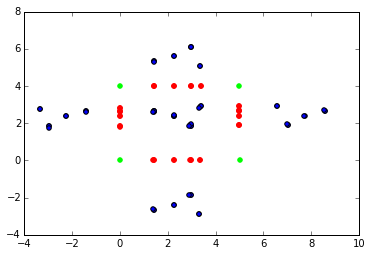

In [125]:
imagedata = ImageSourceData(results, 6, r, (w,l,h))
wall_points,vertices = imagedata.find_walls(threshold=0.05, bestN=5)
im = np.vstack(imagedata.images)
plt.scatter(im[:,0], im[:,1])
wp = np.vstack(wall_points)
plt.scatter(wp[:,0], wp[:,1], color=(1,0,0,1))
plt.scatter(vertices[:,0], vertices[:,1], color=(0,1,0,1))